<a href="https://colab.research.google.com/github/naenumtou/learnTensorflow/blob/main/OCRModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Change working
%cd /content/drive/My Drive/Colab Notebooks/ocr

/content/drive/My Drive/Colab Notebooks/ocr


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Neural network libraies
import tensorflow as tf
print(f'Tensorflow version: {tf.__version__}')

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Checking GPU available
if tf.test.gpu_device_name() == '/device:GPU:0':
  print('GPU is available')
else:
  print('GPU is not available')

# Config display
%config InlineBackend.figure_format = 'retina'

Tensorflow version: 2.3.0
GPU is available


In [ ]:
# Import A-Z dataset
az_data = pd.read_csv('A_Z Handwritten Data.csv')
print(f'Total rows: {az_data.shape[0]}, Total columns: {az_data.shape[1]}')

Total rows: 372450, Total columns: 785


In [ ]:
# Extra A-Z images from dataframe
az_labels = []
az_images = []

for i in range(az_data.shape[0]):
  if i % 50000 == 0:
    print(f'Processing image done: {i}')
  label = az_data.iloc[i][0]
  image = az_data.iloc[i][1:].values
  image = image.reshape((28, 28))

  #Append data
  az_labels.append(label)
  az_images.append(image)

del az_data

#Covert to numpy array
az_labels = np.array(az_labels)
az_images = np.array(az_images)
print(f'A-Z Labels shape: {az_labels.shape}')
print(f'A-Z Images shape: {az_images.shape}')

Processing image done: 0
Processing image done: 50000
Processing image done: 100000
Processing image done: 150000
Processing image done: 200000
Processing image done: 250000
Processing image done: 300000
Processing image done: 350000
A-Z Labels shape: (372450,)
A-Z Images shape: (372450, 28, 28)


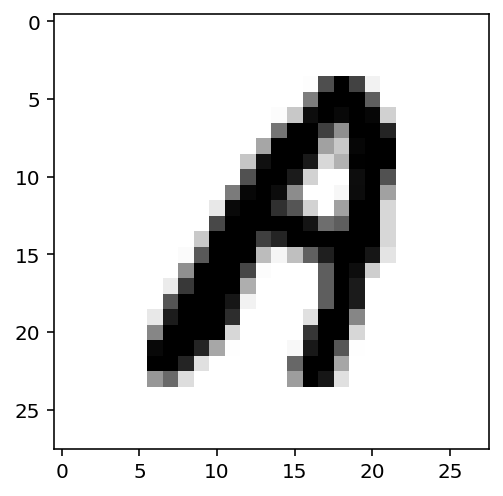

0


In [ ]:
# Show A-Z images
plt.imshow(az_images[0] , cmap = plt.cm.binary)
plt.show()
print(az_labels[0])

In [ ]:
# Import MNIST dataset (0-9)
((mnist_images_train, mnist_labels_train), (mnist_images_test, mnist_labels_test)) = mnist.load_data()
print(f'MNIST Train shape: {mnist_images_train.shape}')
print(f'MNIST Test shape: {mnist_images_test.shape}')

MNIST Train shape: (60000, 28, 28)
MNIST Test shape: (10000, 28, 28)


In [ ]:
# Combine MNIST dataset
mnist_labels = np.hstack([mnist_labels_train, mnist_labels_test])
mnist_images = np.vstack([mnist_images_train, mnist_images_test])

del mnist_labels_train, mnist_labels_test, mnist_images_train, mnist_images_test

print(f'MNIST Labels shape: {mnist_labels.shape}')
print(f'MNIST Images shape: {mnist_images.shape}')

MNIST Labels shape: (70000,)
MNIST Images shape: (70000, 28, 28)


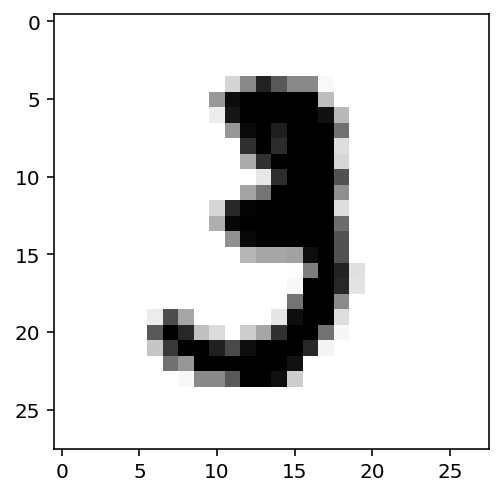

3


In [ ]:
# Show MNIST images
plt.imshow(mnist_images[10] , cmap = plt.cm.binary)
plt.show()
print(mnist_labels[10])

In [ ]:
# Combine A-Z and MNIST dataset
az_labels = az_labels + 10 #This to ensure that A-Z labels is not overlab with MNIST (0-9 labels)

labels = np.hstack((az_labels, mnist_labels))
images = np.vstack((az_images, mnist_images))

del az_labels, mnist_labels, az_images, mnist_images

print(f'Labels shape: {labels.shape}')
print(f'Images shape: {images.shape}')

# Convert images to float32
images = images.astype(np.float32)

Labels shape: (442450,)
Images shape: (442450, 28, 28)


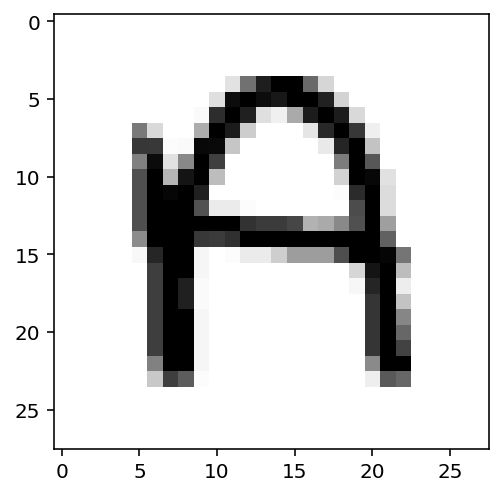

10


In [ ]:
# Show images
plt.imshow(images[100] , cmap = plt.cm.binary)
plt.show()
print(labels[100])

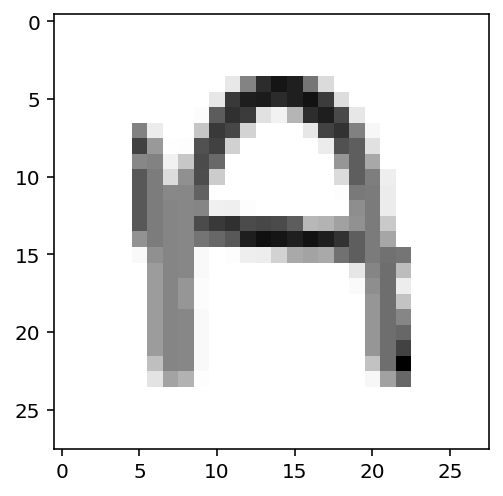

10


In [ ]:
# Normalised images to be (0-1)
images = normalize(images, axis = 1)

# Show images
plt.imshow(images[100] , cmap = plt.cm.binary)
plt.show()
print(labels[100])

In [ ]:
# Reshape images for neural network
images = images.reshape(images.shape[0], 28, 28, 1)
print(f'Reshape images shape: {images.shape}')

Reshape images shape: (442450, 28, 28, 1)


In [ ]:
# Train test splits
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.20, random_state = 777)

del images, labels

print(f'Training images shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing images shape: {X_test.shape}')
print(f'Testing labels shape: {y_test.shape}')

Training images shape: (353960, 28, 28, 1)
Training labels shape: (353960,)
Testing images shape: (88490, 28, 28, 1)
Testing labels shape: (88490,)


In [ ]:
# Model condition
# Images augmentation
aug = ImageDataGenerator(rotation_range = 10,
                         zoom_range = 0.05,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         shear_range = 0.2,
                         horizontal_flip = False,
                         fill_mode = 'nearest')

#Defining the optimizer
optz = tf.keras.optimizers.Adam(lr = 0.01)

In [ ]:
# Neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = X_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(36, activation = 'softmax')) #(0-9) + (A-Z) = 36
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optz, metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [ ]:
# Fit model
logs = model.fit(aug.flow(X_train, y_train, batch_size = 512), validation_data = (X_test, y_test), epochs = 10)

Epoch 1/10
692/692 [==============================] - 95s 138ms/step - loss: 0.6617 - accuracy: 0.8084 - val_loss: 0.1964 - val_accuracy: 0.9400
Epoch 2/10
692/692 [==============================] - 96s 138ms/step - loss: 0.3237 - accuracy: 0.9040 - val_loss: 0.1694 - val_accuracy: 0.9485
Epoch 3/10
692/692 [==============================] - 95s 138ms/step - loss: 0.2915 - accuracy: 0.9139 - val_loss: 0.1708 - val_accuracy: 0.9475
Epoch 4/10
692/692 [==============================] - 95s 138ms/step - loss: 0.2774 - accuracy: 0.9186 - val_loss: 0.1662 - val_accuracy: 0.9510
Epoch 5/10
692/692 [==============================] - 96s 139ms/step - loss: 0.2706 - accuracy: 0.9200 - val_loss: 0.1500 - val_accuracy: 0.9542
Epoch 6/10
692/692 [==============================] - 95s 138ms/step - loss: 0.2647 - accuracy: 0.9219 - val_loss: 0.1574 - val_accuracy: 0.9526
Epoch 7/10
692/692 [==============================] - 96s 138ms/step - loss: 0.2696 - accuracy: 0.9208 - val_loss: 0.1459 - val_ac

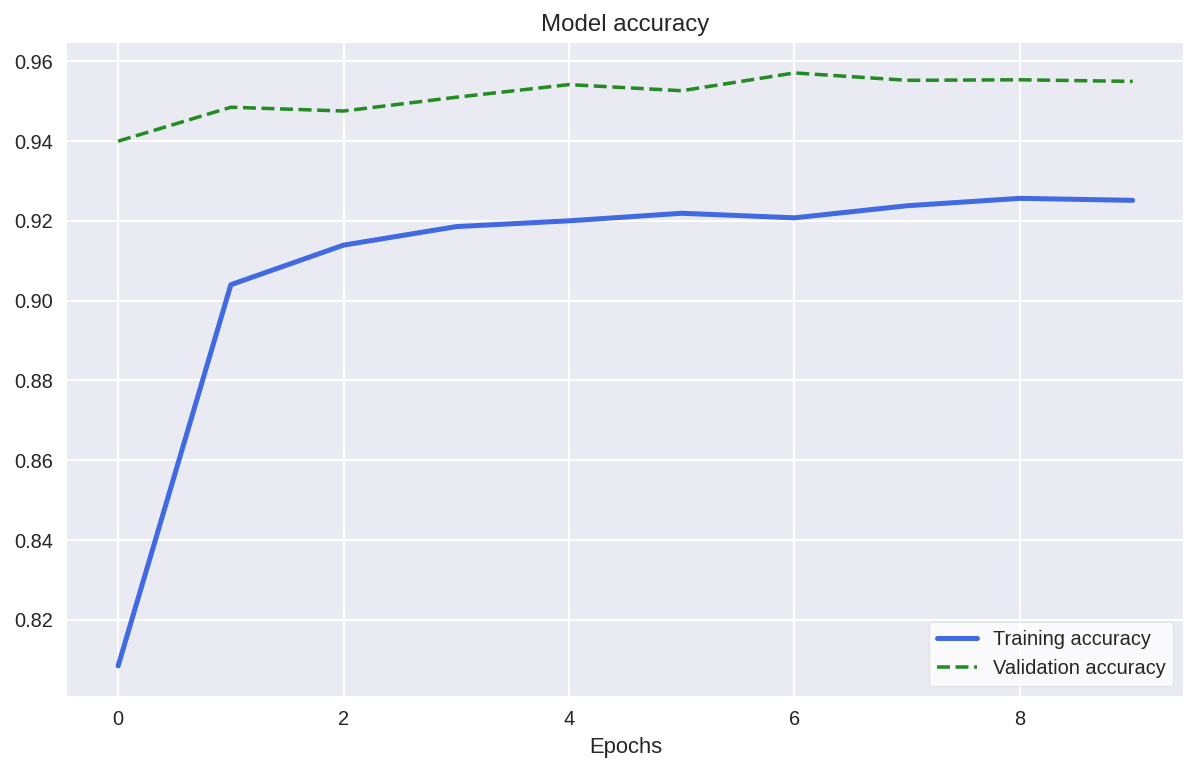

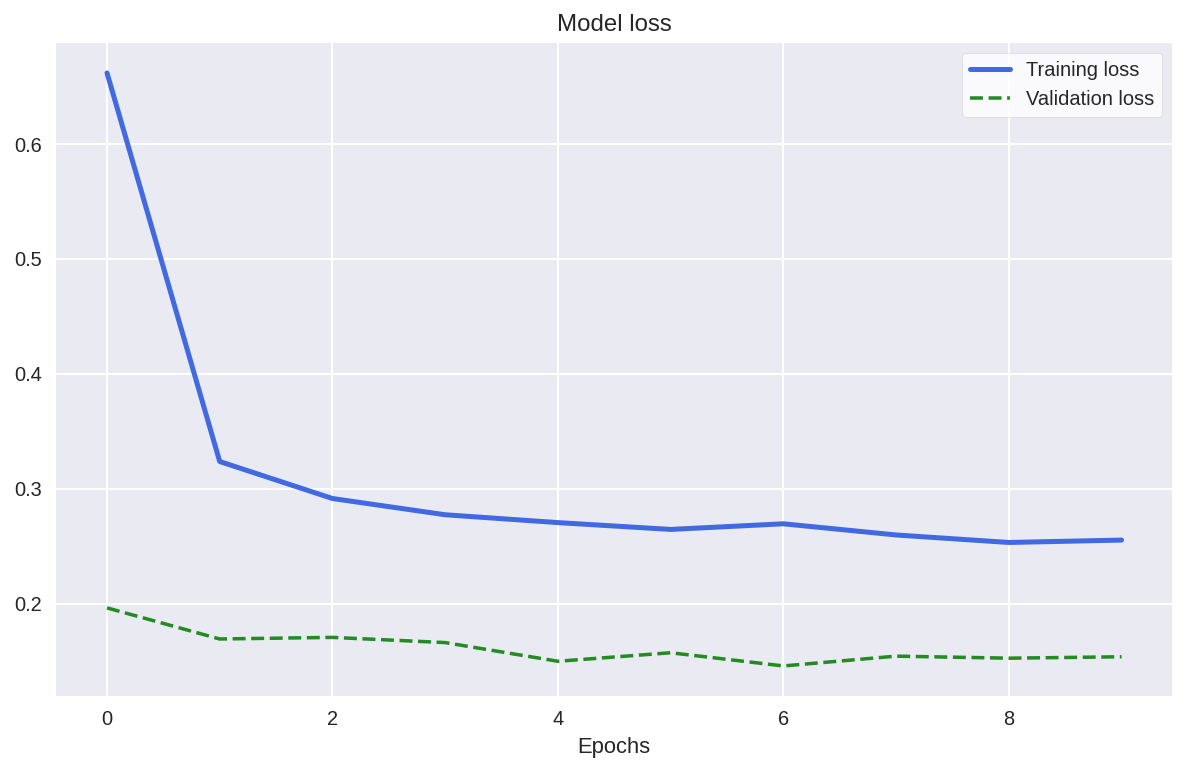

In [ ]:
# Plot loss function
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Model accuracy')
  plt.xlabel('Epochs')
  plt.plot(logs.history['accuracy'], c = 'royalblue', linewidth = 2.5, label = 'Training accuracy')
  plt.plot(logs.history['val_accuracy'], c = 'forestgreen', linestyle = '--', label = 'Validation accuracy')
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()

plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Model loss')
  plt.xlabel('Epochs')
  plt.plot(logs.history['loss'], c = 'royalblue', linewidth = 2.5, label = 'Training loss')
  plt.plot(logs.history['val_loss'], c = 'forestgreen', linestyle = '--', label = 'Validation loss')
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()

In [ ]:
# Evaluate model
print(f'Model loss: {model.evaluate(X_test, y_test)[0]:.4f}, Model accuracy: {model.evaluate(X_test, y_test)[1]:.4f}')

2766/2766 [==============================] - 7s 2ms/step - loss: 0.1539 - accuracy: 0.9550
Model loss: 0.1539, Model accuracy: 0.9550


In [ ]:
# Save model
model.save('ocr.model')

In [ ]:
# Prediction
label_names = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pred = model.predict(X_test).argmax(axis = 1) #Array of prediction results

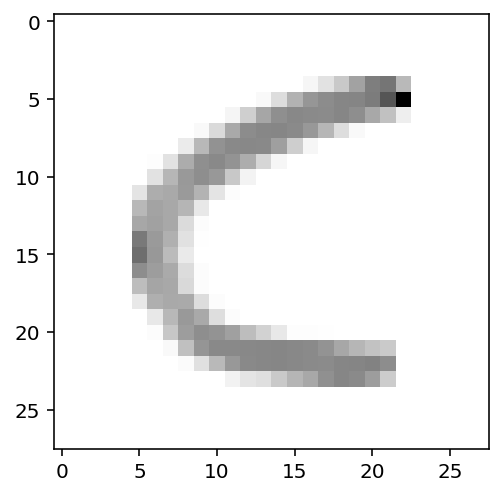

Prediction from model: C


In [ ]:
# Random test model
for i in np.random.choice(X_test.shape[0], 1):
  prediction = label_names[pred[i]]
  plt.imshow(X_test[i].reshape(28,28), cmap = plt.cm.binary)
  plt.show()
  print(f'Prediction from model: {prediction}')

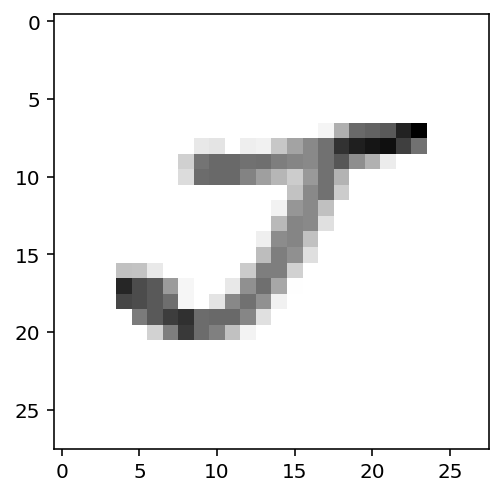

Prediction from model: J


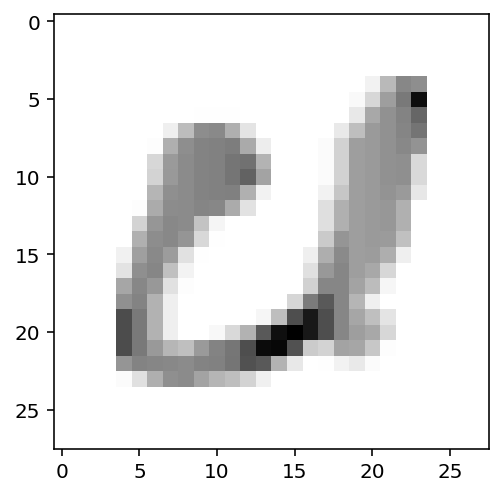

Prediction from model: U


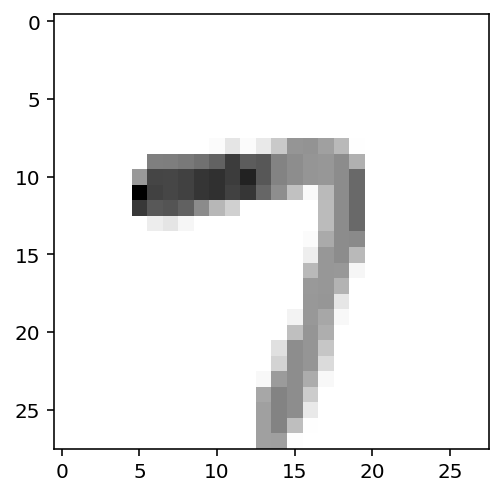

Prediction from model: 7


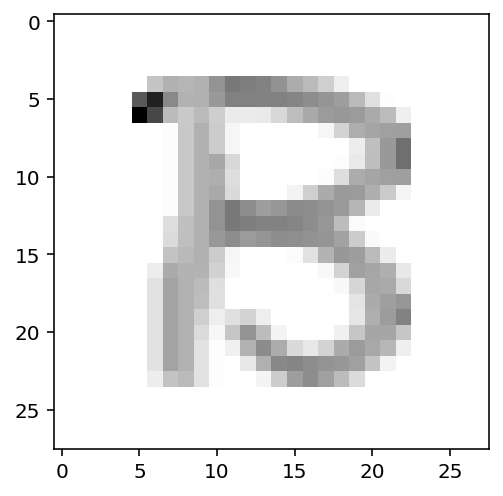

Prediction from model: B


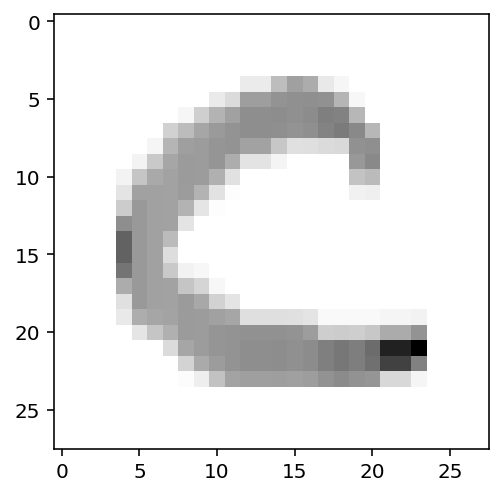

Prediction from model: C


In [ ]:
# Random test model
for i in range(45, 50):
  prediction = label_names[pred[i]]
  plt.imshow(X_test[i].reshape(28,28), cmap = plt.cm.binary)
  plt.show()
  print(f'Prediction from model: {prediction}')